In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import os, sys
import glob
import numpy as np
import torch
import pandas as pd
import random
import torch.nn as nn
import pickle
import torch.nn.functional as F

In [3]:
from model import C2F_TCN
from utility.adaptive_data_loader import Breakfast, collate_fn_override
from utils import calculate_mof, dotdict

In [4]:
os.environ["WANDB_API_KEY"] = "992b3b1371ba79f48484cfca522b3786d7fa52c2"
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dipika_singhania (use `wandb login --relogin` to force relogin)


True

In [5]:
seed = 42

# Ensure deterministic behavior
def set_seed():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
set_seed()

# Device configuration
os.environ['CUDA_VISIBLE_DEVICES']='1'
# os.environ['CUDA_LAUNCH_BLOCKING']='6'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
config = dotdict(
    epochs=500,
    num_class=48,
    batch_size=12,
    learning_rate=5e-4,
    weight_decay=0,
    dataset="Breakfast",
    architecture="unet-ensemble",
    features_file_name="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/",
    chunk_size=1,
    max_frames_per_video=1200,
    feature_size=2048,
    ground_truth_files_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/",
    label_id_csv="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv",
    gamma=0.1,
    step_size=500,
    split=2,
#     output_dir="/mnt/data/ar-datasets/dipika/breakfast/ms_tcn/data/breakfast/results/unsuper-finetune-split2-0.05-data-llr/",
    output_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/fullsupervised-c2ftcn-split2/",
    project_name="breakfast-split-2",
    train_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split{}.bundle",
    test_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split{}.bundle",
    all_files="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt",
    cutoff=8,
    data_per = 0.2,
    budget=40,
    semi_supervised_split="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/semi_supervised/train.split{}_amt{}.bundle")

config.train_split_file = config.train_split_file.format(config.split)
config.semi_supervised_split = config.semi_supervised_split.format(config.split, config.data_per)
config.test_split_file = config.test_split_file.format(config.split)

if not os.path.exists(config.output_dir):
    os.mkdir(config.output_dir)

print(config)

{'epochs': 500, 'num_class': 48, 'batch_size': 12, 'learning_rate': 0.0005, 'weight_decay': 0, 'dataset': 'Breakfast', 'architecture': 'unet-ensemble', 'features_file_name': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/', 'chunk_size': 1, 'max_frames_per_video': 1200, 'feature_size': 2048, 'ground_truth_files_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/', 'label_id_csv': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv', 'gamma': 0.1, 'step_size': 500, 'split': 2, 'output_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/fullsupervised-c2ftcn-split2/', 'project_name': 'breakfast-split-2', 'train_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split2.bundle', 'test_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split2.bundle', 'all_files': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt', 'cutoff': 8, 'data_per': 0.2, 'budget': 40, 'semi_supervised_sp

In [7]:
traindataset = Breakfast(config, fold='train', fold_file_name=config.train_split_file)
testdataset = Breakfast(config, fold='test', fold_file_name=config.test_split_file)

Number of videos logged in train fold is 1261
Number of videos not found in train fold is 0
Number of videos logged in test fold is 451
Number of videos not found in test fold is 0


In [8]:
def _init_fn(worker_id):
    np.random.seed(int(seed))
trainloader = torch.utils.data.DataLoader(dataset=traindataset,
                                          batch_size=config.batch_size, 
                                          shuffle=True,
                                          pin_memory=True, num_workers=4, 
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)
testloader = torch.utils.data.DataLoader(dataset=testdataset,
                                          batch_size=config.batch_size, 
                                          shuffle=False,
                                          pin_memory=True, num_workers=4,
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)

In [9]:
# item = iter(trainloader).next()
# print(item[0]) # -- data feature
# print(item[1]) # -- valid count
# item[2] # -- Actual labels
# print(item[5]) # video names
# video_id_boundary_frames

In [10]:
loaded_vidid_selected_frames = np.load("/home/dipika16/ar/TimestampActionSeg/data/breakfast_annotation_all.npy", allow_pickle=True).item()
# loaded_vidid_selected_frames
video_id_boundary_frames = pickle.load(open("dump_dir/chunk_1_video_id_boundary_frames_dict.pkl", "rb"))
# video_id_boundary_frames

In [11]:
loaded_mean_var_actions = pickle.load(open("dump_dir/mean_var_actions.pkl", "rb"))
def get_possion_prob(cur_len, cur_class):
    mean_class, std_class = loaded_mean_var_actions[cur_class]
    mean_class = mean_class * 10
    prob = cur_len * torch.log(torch.tensor(mean_class, device=device) + 1e-5)
    prob = prob - mean_class
    factorials = torch.cumsum(torch.log(torch.arange(1, torch.max(cur_len)+1, 1).type(torch.float).to(device)), 
                              dim=0)[min(cur_len)-1:]
    prob = prob - factorials
    return prob

# get_possion_prob(torch.arange(10, 21), 20)

In [12]:
prob_video_each_segment_dict = {}

In [13]:
def prob_vals_per_segment(selected_frames, cur_vid_feat, labels):
    prob_each_segment = []
    
    log_probs = torch.log(cur_vid_feat + 1e-8)
    cumsum_feat = torch.cumsum(log_probs, dim=0)
    cur_boundary = 0
    for i, cur_ele in enumerate(selected_frames[:-1]):

        next_ele = selected_frames[i + 1]
        label_cur_ele = labels[cur_ele]
        label_next_ele = labels[next_ele]

        indices = torch.arange(cur_ele, next_ele).to(cumsum_feat.device)
        strt_index = cumsum_feat[cur_ele - 1, :][None, :] if cur_ele > 0 else 0
        end_index = cumsum_feat[next_ele - 1, :][None, :]
        left_sum = (cumsum_feat[indices, :] - strt_index)[:,label_cur_ele]
        right_sum = (end_index - cumsum_feat[indices, :])[:,label_next_ele]

        cur_boundary_len = indices - cur_boundary
        len_prob = get_possion_prob(cur_boundary_len, label_cur_ele.item())

        prob = torch.softmax((left_sum + right_sum + len_prob), dim=0)
#         prob = torch.softmax((left_sum + right_sum), dim=0)

        cur_boundary = round(np.sum(np.arange(cur_ele, next_ele, 1) * prob.detach().cpu().numpy()).item())
        prob_each_segment.append(prob)
    
    return prob_each_segment

In [14]:
selected_frames = torch.tensor([2, 10, 17, 21])
cur_vid_feat = torch.randn((27, 48))
labels = torch.tensor([47, 47, 47, 47, 47, 4, 4, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10])
# print(len(labels))
# probs_all_segs = prob_vals_per_segment_new(selected_frames, cur_vid_feat, labels)
# print(probs_all_segs)



In [15]:
def calculate_element_probb(data_feat, data_count, video_ids, labels_all): #, loaded_vidid_selected_frames, boundaries_dict):
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        labels = labels_all[iter_num]
        
        selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
        prob_video = prob_vals_per_segment(selected_frames, cur_vid_feat, labels)
        prob_video_each_segment_dict[cur_vidid] = prob_video

In [16]:
def get_estimated_loss(data_feat, data_count, video_ids, labels_all): #, loaded_vidid_selected_frames, boundaries_dict):
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    loss_arr = []
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        labels = labels_all[iter_num]
        
        selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
        prob_each_video = prob_video_each_segment_dict[cur_vidid]
        
        log_probs = torch.log(cur_vid_feat + 1e-8)
        cumsum_feat = torch.cumsum(log_probs, dim=0)
        
        
        current_vid_prob_arr = []
        # Start segment log probability
        start_ele_idx = selected_frames[0]
        if start_ele_idx > 0:
            start_ele_label_idx = labels[selected_frames[0]]
            first_segment_prob = (cumsum_feat[start_ele_idx - 1, :])[start_ele_label_idx]
            current_vid_prob_arr.append(first_segment_prob.unsqueeze(0))
        
        for i, cur_ele in enumerate(selected_frames[:-1]):
            next_ele = selected_frames[i + 1]
            label_cur_ele = labels[cur_ele]
            label_next_ele = labels[next_ele]

            indices = torch.arange(cur_ele, next_ele)
            strt_index = cumsum_feat[cur_ele - 1, :][None, :] if cur_ele > 0 else 0
            end_index = cumsum_feat[next_ele - 1, :][None, :]
            left_sum = (cumsum_feat[indices, :] - strt_index)[:,label_cur_ele]
            right_sum = (end_index - cumsum_feat[indices, :])[:,label_next_ele]
            current_vid_prob_arr.append((left_sum + right_sum)  * (prob_each_video[i]))
        
        # End segment log probability
        end_index = cur_vid_count.item() - 1
        last_ele_label_idx = labels[selected_frames[-1]]
        last_segment_sum_prob = (cumsum_feat[end_index, :] - cumsum_feat[selected_frames[-1] - 1, :])[last_ele_label_idx]
        current_vid_prob_arr.append(last_segment_sum_prob.unsqueeze(0))
            
        loss_arr.append(torch.cat(current_vid_prob_arr))
    return -torch.mean(torch.cat(loss_arr)), loss_arr

In [17]:
train_split_file_list = set(open(config.train_split_file).read().split("\n")[0:-1])

def get_estimated_boundaries():
    global prob_video_each_segment_dict, loaded_vidid_selected_frames, video_id_boundary_frames
    estimated_boundary_dict = {}
    for ele in video_id_boundary_frames.keys():
        if (ele + ".txt") not in train_split_file_list:
            continue
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        selected_ele_list = loaded_vidid_selected_frames[ele + ".txt"]
        boundary_list = []
        for i, segment in enumerate(estimated_boundary_probs):
            estimated_boundary = np.sum(np.arange(selected_ele_list[i], selected_ele_list[i + 1], 1) \
                                        * segment.detach().cpu().numpy())
            estimated_boundary = round(estimated_boundary.item())
            
            if (estimated_boundary < selected_ele_list[i]) or (estimated_boundary > selected_ele_list[i + 1]):
                print("Estimated value wrong")
                import pdb
                pdb.set_trace()
            boundary_list.append(estimated_boundary)

        estimated_boundary_dict[ele] = boundary_list
    return estimated_boundary_dict

In [18]:
train_split_file_list = set(open(config.train_split_file).read().split("\n")[0:-1])

def get_boundary_err():
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    err_list = []
    correct = 0.0
    total = 0.0
    estimated_boundar_dict = get_estimated_boundaries()
    for ele in video_id_boundary_frames.keys():
        if ele + ".txt" not in train_split_file_list:
            continue
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        estimated_boundary_list = estimated_boundar_dict[ele]
        
        estimated = np.array(estimated_boundary_list) #.detach().cpu().numpy()
        actual = np.array(video_id_boundary_frames[ele][:-1])
        if len(actual) != len(estimated):
            print(ele)
            continue
        
        mse_err = (actual - estimated)**2
        err_list.append(mse_err)
        
        estimated_labels = []
        actual_labels = []
        start_v1 = 0
        start_v2 = 0
        for i, v1 in enumerate(estimated):
            estimated_labels.extend([i] * (v1 - start_v1))
            start_v1 = v1
            v2 = actual[i]
            actual_labels.extend([i] * (v2 - start_v2))
            start_v2 = v2
            
        last_ele = video_id_boundary_frames[ele][-1]
        estimated_labels.extend([i+1] * (last_ele - start_v1))
        actual_labels.extend([i+1] * (last_ele - start_v2))
        
        correct += np.sum(np.array(actual_labels) == np.array(estimated_labels))
        total += len(actual_labels)
        
    print(f"Train Boundary avergage error = {np.sqrt(np.mean(np.concatenate(err_list))):.3f}")
    print(f"Train From boundary avergage accuracy = {correct * 100.0 / total:.3f}")

In [19]:
def get_ensemble_out(outp):
        
        weights = [1, 1, 1, 1, 1, 1]
        vidlen = outp[0].shape[-1]
        ensemble_prob = F.softmax(outp[0], dim=1) * weights[0] / sum(weights)

        for i, outp_ele in enumerate(outp[1]):
            upped_logit = F.upsample(outp_ele, size=vidlen, mode='nearest')
            ensemble_prob = ensemble_prob + F.softmax(upped_logit, dim=1) * weights[i+1] / sum(weights)
        
        return ensemble_prob


In [20]:
set_seed()
model = C2F_TCN(n_channels=2048, n_classes=48).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

# Requires loaded_vidid_selected_frames, boundaries_dict
ce_criterion = nn.CrossEntropyLoss(ignore_index=-100)
mse_criterion = nn.MSELoss(reduction='none')

In [21]:
def get_single_random(labels_all, video_ids):
    # Generate target for only timestamps. Do not generate pseudo labels at first 30 epochs.
    boundary_target_tensor = torch.ones((labels_all.shape[0], labels_all.shape[1]), dtype=torch.long, device=labels_all.device) * (-100)
    for iter_num, labels in enumerate(labels_all):
        cur_vidid = video_ids[iter_num]
        frame_idx_tensor = torch.from_numpy(np.array(loaded_vidid_selected_frames[cur_vidid + ".txt"]))
        boundary_target_tensor[iter_num, frame_idx_tensor] = labels[frame_idx_tensor]

    return boundary_target_tensor

In [22]:
initialize_epoch = 50
expectation_cal_gap = 5
best_val_acc = 0.0
for epoch in range(400):
    print("Starting Training")
    model.train()
    for i, item in enumerate(trainloader):
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)
        optimizer.zero_grad()
        
        y, y_list, x = model(item_0)
        probs = torch.softmax(y, dim=1) # get_ensemble_out([y, y_list])
#         logits = torch.log(probs + 1e-8)
        
        loss = 0
        loss += ce_criterion(y, item_2)
        loss += 0.15 * torch.mean(torch.clamp(mse_criterion(F.log_softmax(y[:, :, 1:], dim=1), 
                                                            F.log_softmax(y.detach()[:, :, :-1], dim=1)), min=0,
                                        max=16) * src_mask_mse[:, :, 1:])
            

        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            with torch.no_grad():
                pred = torch.argmax(probs, dim=1)
                correct = float(torch.sum((pred == item_2) * src_mask).item())
                total = float(torch.sum(src_mask).item())
                print(f"Training:: Epoch {epoch}, Iteration {i}, Current loss {loss.item()}" +
                      f" Accuracy {correct * 100.0 / total}")
                
    # Calculating Expectation Step
    model.eval()

    if epoch % 1 == 0:
        
        print("Calculating Validation Data Accuracy")
        correct = 0.0
        total = 0.0
        for i, item in enumerate(testloader):
            with torch.no_grad():
                item_0 = item[0].to(device)
                item_1 = item[1].to(device)
                item_2 = item[2].to(device)
                src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
                src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

                y, y_list, x = model(item_0)
                probs = torch.softmax(y, dim=1) # get_ensemble_out([y, y_list])
                
                pred = torch.argmax(probs, dim=1)
                correct += float(torch.sum((pred == item_2) * src_mask).item())
                total += float(torch.sum(src_mask).item())
        val_acc = correct * 100.0 / total
        if val_acc > best_val_acc:
            torch.save(model.state_dict(), config.output_dir + "c2f-tcn-emmax-best-model.wt")
        torch.save(model.state_dict(), config.output_dir + "c2f-tcn-emmax-last-model.wt")
        print(f"Validation:: Epoch {epoch}, Probability Accuracy {correct * 100.0 / total}")

Starting Training


/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Training:: Epoch 0, Iteration 0, Current loss 3.917290210723877 Accuracy 4.048159134531495
Training:: Epoch 0, Iteration 10, Current loss 3.7912206649780273 Accuracy 2.8741328047571852
Training:: Epoch 0, Iteration 20, Current loss 3.5595016479492188 Accuracy 11.242704142347142
Training:: Epoch 0, Iteration 30, Current loss 3.296705961227417 Accuracy 24.961967152038252
Training:: Epoch 0, Iteration 40, Current loss 2.9616641998291016 Accuracy 32.17869087434305
Training:: Epoch 0, Iteration 50, Current loss 3.2367687225341797 Accuracy 20.64052702595444
Training:: Epoch 0, Iteration 60, Current loss 3.174970865249634 Accuracy 17.247565351102
Training:: Epoch 0, Iteration 70, Current loss 2.829922676086426 Accuracy 26.706960872205673
Training:: Epoch 0, Iteration 80, Current loss 2.74573016166687 Accuracy 25.99086860312036
Training:: Epoch 0, Iteration 90, Current loss 2.7673542499542236 Accuracy 40.68290314750384
Training:: Epoch 0, Iteration 100, Current loss 2.8317387104034424 Accuracy

Training:: Epoch 7, Iteration 30, Current loss 1.4511733055114746 Accuracy 64.80456079420726
Training:: Epoch 7, Iteration 40, Current loss 1.467482089996338 Accuracy 60.68353306702175
Training:: Epoch 7, Iteration 50, Current loss 1.6432359218597412 Accuracy 54.825038657579746
Training:: Epoch 7, Iteration 60, Current loss 1.4701894521713257 Accuracy 57.94500500654702
Training:: Epoch 7, Iteration 70, Current loss 1.6034448146820068 Accuracy 56.561217565515236
Training:: Epoch 7, Iteration 80, Current loss 1.3515931367874146 Accuracy 64.35549201810817
Training:: Epoch 7, Iteration 90, Current loss 1.4517549276351929 Accuracy 58.19922113264205
Training:: Epoch 7, Iteration 100, Current loss 1.2805202007293701 Accuracy 65.34252775633004
Calculating Validation Data Accuracy
Validation:: Epoch 7, Probability Accuracy 42.75904213448233
Starting Training
Training:: Epoch 8, Iteration 0, Current loss 1.2728251218795776 Accuracy 67.4015699742426
Training:: Epoch 8, Iteration 10, Current loss 

Training:: Epoch 14, Iteration 50, Current loss 0.8983643651008606 Accuracy 72.77789150460593
Training:: Epoch 14, Iteration 60, Current loss 1.020982265472412 Accuracy 71.6130453944469
Training:: Epoch 14, Iteration 70, Current loss 0.8560483455657959 Accuracy 74.67153284671532
Training:: Epoch 14, Iteration 80, Current loss 0.8679929375648499 Accuracy 73.9433049089652
Training:: Epoch 14, Iteration 90, Current loss 0.8920577168464661 Accuracy 76.52412379833046
Training:: Epoch 14, Iteration 100, Current loss 1.1127408742904663 Accuracy 70.83452007974935
Calculating Validation Data Accuracy
Validation:: Epoch 14, Probability Accuracy 44.61428512242615
Starting Training
Training:: Epoch 15, Iteration 0, Current loss 0.6831477284431458 Accuracy 77.03475897582607
Training:: Epoch 15, Iteration 10, Current loss 0.8670005202293396 Accuracy 75.46602894285013
Training:: Epoch 15, Iteration 20, Current loss 0.7496782541275024 Accuracy 79.57327237224365
Training:: Epoch 15, Iteration 30, Curre

Training:: Epoch 21, Iteration 70, Current loss 0.47582772374153137 Accuracy 87.31190978587983
Training:: Epoch 21, Iteration 80, Current loss 0.9939087629318237 Accuracy 73.59525899912204
Training:: Epoch 21, Iteration 90, Current loss 0.8717333078384399 Accuracy 73.96014307613694
Training:: Epoch 21, Iteration 100, Current loss 0.4713751971721649 Accuracy 87.8361780526026
Calculating Validation Data Accuracy
Validation:: Epoch 21, Probability Accuracy 45.891991548245436
Starting Training
Training:: Epoch 22, Iteration 0, Current loss 0.5726208686828613 Accuracy 83.60723575313312
Training:: Epoch 22, Iteration 10, Current loss 0.8087828159332275 Accuracy 79.31085404873247
Training:: Epoch 22, Iteration 20, Current loss 0.5961409211158752 Accuracy 82.3606941495204
Training:: Epoch 22, Iteration 30, Current loss 0.6765402555465698 Accuracy 80.22388059701493
Training:: Epoch 22, Iteration 40, Current loss 0.5400852560997009 Accuracy 83.97334179625516
Training:: Epoch 22, Iteration 50, Cu

Training:: Epoch 28, Iteration 90, Current loss 0.474159836769104 Accuracy 88.62680335275606
Training:: Epoch 28, Iteration 100, Current loss 0.3970343768596649 Accuracy 90.91652358760527
Calculating Validation Data Accuracy
Validation:: Epoch 28, Probability Accuracy 42.70280067945478
Starting Training
Training:: Epoch 29, Iteration 0, Current loss 0.46678298711776733 Accuracy 86.40503919880365
Training:: Epoch 29, Iteration 10, Current loss 0.5901486873626709 Accuracy 81.72786778701082
Training:: Epoch 29, Iteration 20, Current loss 0.4024909734725952 Accuracy 90.19958576539258
Training:: Epoch 29, Iteration 30, Current loss 0.6046680808067322 Accuracy 82.91369269168455
Training:: Epoch 29, Iteration 40, Current loss 0.4233800768852234 Accuracy 86.69393784444065
Training:: Epoch 29, Iteration 50, Current loss 0.3564354181289673 Accuracy 89.75579211020664
Training:: Epoch 29, Iteration 60, Current loss 0.37330904603004456 Accuracy 89.22599933562175
Training:: Epoch 29, Iteration 70, C

Training:: Epoch 37, Iteration 60, Current loss 0.16153424978256226 Accuracy 95.25893268408238
Training:: Epoch 37, Iteration 70, Current loss 0.36529454588890076 Accuracy 89.95357948980026
Training:: Epoch 37, Iteration 80, Current loss 0.3481544256210327 Accuracy 91.20784670610243
Training:: Epoch 37, Iteration 90, Current loss 0.25349345803260803 Accuracy 91.78124709022626
Training:: Epoch 37, Iteration 100, Current loss 0.20361006259918213 Accuracy 94.35985701045942
Calculating Validation Data Accuracy
Validation:: Epoch 37, Probability Accuracy 43.17769399676845
Starting Training
Training:: Epoch 38, Iteration 0, Current loss 0.23664182424545288 Accuracy 93.68384521950374
Training:: Epoch 38, Iteration 10, Current loss 0.4301421642303467 Accuracy 89.98899024850581
Training:: Epoch 38, Iteration 20, Current loss 0.4278266131877899 Accuracy 87.47083757762955
Training:: Epoch 38, Iteration 30, Current loss 0.2754284739494324 Accuracy 90.63172492946296
Training:: Epoch 38, Iteration 4

Training:: Epoch 44, Iteration 80, Current loss 0.18038742244243622 Accuracy 94.48499845344881
Training:: Epoch 44, Iteration 90, Current loss 0.2256098985671997 Accuracy 93.34759866856871
Training:: Epoch 44, Iteration 100, Current loss 0.2967267632484436 Accuracy 93.41424424719196
Calculating Validation Data Accuracy
Validation:: Epoch 44, Probability Accuracy 46.02094295065667
Starting Training
Training:: Epoch 45, Iteration 0, Current loss 0.09738133102655411 Accuracy 97.16278263882873
Training:: Epoch 45, Iteration 10, Current loss 0.21051670610904694 Accuracy 95.31295572536895
Training:: Epoch 45, Iteration 20, Current loss 0.4208747446537018 Accuracy 88.91078466499462
Training:: Epoch 45, Iteration 30, Current loss 0.2727905511856079 Accuracy 90.9875876956287
Training:: Epoch 45, Iteration 40, Current loss 0.3014087975025177 Accuracy 91.44242019053986
Training:: Epoch 45, Iteration 50, Current loss 0.43143928050994873 Accuracy 86.94024478041757
Training:: Epoch 45, Iteration 60,

Training:: Epoch 51, Iteration 100, Current loss 0.10155852884054184 Accuracy 97.3789816904941
Calculating Validation Data Accuracy
Validation:: Epoch 51, Probability Accuracy 46.372270787587524
Starting Training
Training:: Epoch 52, Iteration 0, Current loss 0.12050569802522659 Accuracy 96.96459936174949
Training:: Epoch 52, Iteration 10, Current loss 0.3830178678035736 Accuracy 90.79160906413416
Training:: Epoch 52, Iteration 20, Current loss 0.4585490822792053 Accuracy 86.71426292278238
Training:: Epoch 52, Iteration 30, Current loss 0.2225940078496933 Accuracy 93.68005047989107
Training:: Epoch 52, Iteration 40, Current loss 0.2238883376121521 Accuracy 93.43374446552815
Training:: Epoch 52, Iteration 50, Current loss 0.21984615921974182 Accuracy 92.88229042115053
Training:: Epoch 52, Iteration 60, Current loss 0.16489490866661072 Accuracy 95.3785135368167
Training:: Epoch 52, Iteration 70, Current loss 0.15397495031356812 Accuracy 95.05035291338118
Training:: Epoch 52, Iteration 80

Calculating Validation Data Accuracy
Validation:: Epoch 58, Probability Accuracy 43.860152463023574
Starting Training
Training:: Epoch 59, Iteration 0, Current loss 0.1261090189218521 Accuracy 96.84429404329921
Training:: Epoch 59, Iteration 10, Current loss 0.14732412993907928 Accuracy 95.70015220700152
Training:: Epoch 59, Iteration 20, Current loss 0.21843372285366058 Accuracy 94.30062211519166
Training:: Epoch 59, Iteration 30, Current loss 0.14537246525287628 Accuracy 95.52131291302578
Training:: Epoch 59, Iteration 40, Current loss 0.11564552038908005 Accuracy 96.87232394079028
Training:: Epoch 59, Iteration 50, Current loss 0.2178802490234375 Accuracy 94.50619712768051
Training:: Epoch 59, Iteration 60, Current loss 0.17366184294223785 Accuracy 94.87689393939394
Training:: Epoch 59, Iteration 70, Current loss 0.1805352419614792 Accuracy 94.65128118106227
Training:: Epoch 59, Iteration 80, Current loss 0.17190557718276978 Accuracy 95.7657467874447
Training:: Epoch 59, Iteration 9

Training:: Epoch 66, Iteration 0, Current loss 0.11172472685575485 Accuracy 96.67385832434375
Training:: Epoch 66, Iteration 10, Current loss 0.15622110664844513 Accuracy 94.98178874949413
Training:: Epoch 66, Iteration 20, Current loss 0.11208449304103851 Accuracy 96.57155427063039
Training:: Epoch 66, Iteration 30, Current loss 0.10167761147022247 Accuracy 96.93243243243244
Training:: Epoch 66, Iteration 40, Current loss 0.10675836354494095 Accuracy 96.24168080386272
Training:: Epoch 66, Iteration 50, Current loss 0.09170003235340118 Accuracy 97.31285988483685
Training:: Epoch 66, Iteration 60, Current loss 0.06969950348138809 Accuracy 98.36774307393682
Training:: Epoch 66, Iteration 70, Current loss 0.09589774906635284 Accuracy 97.10240963855422
Training:: Epoch 66, Iteration 80, Current loss 0.10366518795490265 Accuracy 96.77512444989539
Training:: Epoch 66, Iteration 90, Current loss 0.07478057593107224 Accuracy 97.61086963129578
Training:: Epoch 66, Iteration 100, Current loss 0.

Training:: Epoch 73, Iteration 10, Current loss 0.0836850181221962 Accuracy 97.34345351043643
Training:: Epoch 73, Iteration 20, Current loss 0.12545163929462433 Accuracy 97.10453409014123
Training:: Epoch 73, Iteration 30, Current loss 0.14180706441402435 Accuracy 95.96464258262874
Training:: Epoch 73, Iteration 40, Current loss 0.15697476267814636 Accuracy 95.83620096352374
Training:: Epoch 73, Iteration 50, Current loss 0.17238417267799377 Accuracy 95.48451123555681
Training:: Epoch 73, Iteration 60, Current loss 0.12938615679740906 Accuracy 96.84033858727379
Training:: Epoch 73, Iteration 70, Current loss 0.052557893097400665 Accuracy 98.42006154411428
Training:: Epoch 73, Iteration 80, Current loss 0.05376144498586655 Accuracy 98.35452880828755
Training:: Epoch 73, Iteration 90, Current loss 0.0667339637875557 Accuracy 98.02634619828981
Training:: Epoch 73, Iteration 100, Current loss 0.15709291398525238 Accuracy 95.83748361730014
Calculating Validation Data Accuracy
Validation:: 

Training:: Epoch 80, Iteration 20, Current loss 0.08621279895305634 Accuracy 97.17320991874622
Training:: Epoch 80, Iteration 30, Current loss 0.08457599580287933 Accuracy 97.5570697396929
Training:: Epoch 80, Iteration 40, Current loss 0.0686841607093811 Accuracy 97.73033610156963
Training:: Epoch 80, Iteration 50, Current loss 0.1792612224817276 Accuracy 94.30829807240245
Training:: Epoch 80, Iteration 60, Current loss 0.1690819263458252 Accuracy 94.87505102272212
Training:: Epoch 80, Iteration 70, Current loss 0.0905556008219719 Accuracy 97.59899346450914
Training:: Epoch 80, Iteration 80, Current loss 0.09063340723514557 Accuracy 97.38204623350106
Training:: Epoch 80, Iteration 90, Current loss 0.09881400316953659 Accuracy 96.39007859933167
Training:: Epoch 80, Iteration 100, Current loss 0.2449478656053543 Accuracy 93.81204853574351
Calculating Validation Data Accuracy
Validation:: Epoch 80, Probability Accuracy 45.777229978870615
Starting Training
Training:: Epoch 81, Iteration 0

Training:: Epoch 87, Iteration 30, Current loss 0.0803704783320427 Accuracy 97.58886038842067
Training:: Epoch 87, Iteration 40, Current loss 0.05735111981630325 Accuracy 98.16865815992263
Training:: Epoch 87, Iteration 50, Current loss 0.1975138932466507 Accuracy 96.52685676392574
Training:: Epoch 87, Iteration 60, Current loss 0.06146660074591637 Accuracy 98.29658910306044
Training:: Epoch 87, Iteration 70, Current loss 0.13723962008953094 Accuracy 95.72384137601529
Training:: Epoch 87, Iteration 80, Current loss 0.16961883008480072 Accuracy 94.26884489034893
Training:: Epoch 87, Iteration 90, Current loss 0.05963023751974106 Accuracy 98.15529976378838
Training:: Epoch 87, Iteration 100, Current loss 0.13484929502010345 Accuracy 96.11458798986739
Calculating Validation Data Accuracy
Validation:: Epoch 87, Probability Accuracy 48.134503045117455
Starting Training
Training:: Epoch 88, Iteration 0, Current loss 0.10328249633312225 Accuracy 97.01593760596812
Training:: Epoch 88, Iteratio

Training:: Epoch 94, Iteration 40, Current loss 0.09667320549488068 Accuracy 97.16556981820551
Training:: Epoch 94, Iteration 50, Current loss 0.06441584974527359 Accuracy 97.97818447355209
Training:: Epoch 94, Iteration 60, Current loss 0.0951591208577156 Accuracy 97.29799948038452
Training:: Epoch 94, Iteration 70, Current loss 0.056947752833366394 Accuracy 98.39382940108892
Training:: Epoch 94, Iteration 80, Current loss 0.09029396623373032 Accuracy 97.1423768700622
Training:: Epoch 94, Iteration 90, Current loss 0.14822782576084137 Accuracy 96.14903216416825
Training:: Epoch 94, Iteration 100, Current loss 0.054342467337846756 Accuracy 98.5958485958486
Calculating Validation Data Accuracy
Validation:: Epoch 94, Probability Accuracy 49.16083191780255
Starting Training
Training:: Epoch 95, Iteration 0, Current loss 0.08340480178594589 Accuracy 98.08546484913462
Training:: Epoch 95, Iteration 10, Current loss 0.06796960532665253 Accuracy 97.85770960063475
Training:: Epoch 95, Iteratio

Training:: Epoch 101, Iteration 50, Current loss 0.07645203173160553 Accuracy 97.75904385871306
Training:: Epoch 101, Iteration 60, Current loss 0.06277737021446228 Accuracy 98.1376172874609
Training:: Epoch 101, Iteration 70, Current loss 0.08859521150588989 Accuracy 97.35039107500151
Training:: Epoch 101, Iteration 80, Current loss 0.133977010846138 Accuracy 95.8122785618865
Training:: Epoch 101, Iteration 90, Current loss 0.0811394453048706 Accuracy 97.0574063876652
Training:: Epoch 101, Iteration 100, Current loss 0.07627381384372711 Accuracy 97.11389725637059
Calculating Validation Data Accuracy
Validation:: Epoch 101, Probability Accuracy 45.92917512532626
Starting Training
Training:: Epoch 102, Iteration 0, Current loss 0.08626117557287216 Accuracy 97.35033974869984
Training:: Epoch 102, Iteration 10, Current loss 0.09095043689012527 Accuracy 96.99115986793056
Training:: Epoch 102, Iteration 20, Current loss 0.05928526073694229 Accuracy 98.20220466480579
Training:: Epoch 102, It

Training:: Epoch 108, Iteration 60, Current loss 0.08748374134302139 Accuracy 97.21701899919722
Training:: Epoch 108, Iteration 70, Current loss 0.1217871829867363 Accuracy 96.71236989591674
Training:: Epoch 108, Iteration 80, Current loss 0.0596158467233181 Accuracy 98.07961289834802
Training:: Epoch 108, Iteration 90, Current loss 0.19287365674972534 Accuracy 94.25635892604805
Training:: Epoch 108, Iteration 100, Current loss 0.040193162858486176 Accuracy 98.92837893535399
Calculating Validation Data Accuracy
Validation:: Epoch 108, Probability Accuracy 46.83939594812943
Starting Training
Training:: Epoch 109, Iteration 0, Current loss 0.054539356380701065 Accuracy 98.24370418753175
Training:: Epoch 109, Iteration 10, Current loss 0.06415300816297531 Accuracy 98.20879831796863
Training:: Epoch 109, Iteration 20, Current loss 0.08098548650741577 Accuracy 97.19186729940354
Training:: Epoch 109, Iteration 30, Current loss 0.07691514492034912 Accuracy 97.97371149911717
Training:: Epoch 1

Training:: Epoch 115, Iteration 60, Current loss 0.044454630464315414 Accuracy 98.7125152507545
Training:: Epoch 115, Iteration 70, Current loss 0.048470329493284225 Accuracy 98.43210105888909
Training:: Epoch 115, Iteration 80, Current loss 0.04409634321928024 Accuracy 98.7066637007849
Training:: Epoch 115, Iteration 90, Current loss 0.05740375444293022 Accuracy 98.16395614099639
Training:: Epoch 115, Iteration 100, Current loss 0.04949800297617912 Accuracy 98.38088964393441
Calculating Validation Data Accuracy
Validation:: Epoch 115, Probability Accuracy 46.337780171520905
Starting Training
Training:: Epoch 116, Iteration 0, Current loss 0.06466753780841827 Accuracy 97.73994959302566
Training:: Epoch 116, Iteration 10, Current loss 0.05779729783535004 Accuracy 98.30467675378267
Training:: Epoch 116, Iteration 20, Current loss 0.0436863899230957 Accuracy 98.72639928499609
Training:: Epoch 116, Iteration 30, Current loss 0.05540362000465393 Accuracy 98.16355595532569
Training:: Epoch 1

Training:: Epoch 122, Iteration 60, Current loss 0.06337814778089523 Accuracy 97.91155732679337
Training:: Epoch 122, Iteration 70, Current loss 0.05516152083873749 Accuracy 98.33017796289285
Training:: Epoch 122, Iteration 80, Current loss 0.039543893188238144 Accuracy 98.67188050447403
Training:: Epoch 122, Iteration 90, Current loss 0.0645243376493454 Accuracy 97.67949151904924
Training:: Epoch 122, Iteration 100, Current loss 0.04328259453177452 Accuracy 98.49170962797827
Calculating Validation Data Accuracy
Validation:: Epoch 122, Probability Accuracy 48.091726395160954
Starting Training
Training:: Epoch 123, Iteration 0, Current loss 0.03486746549606323 Accuracy 99.03745743473326
Training:: Epoch 123, Iteration 10, Current loss 0.0987078920006752 Accuracy 96.74145299145299
Training:: Epoch 123, Iteration 20, Current loss 0.04696516692638397 Accuracy 98.63866763215061
Training:: Epoch 123, Iteration 30, Current loss 0.0513247512280941 Accuracy 98.30734556828112
Training:: Epoch 12

Training:: Epoch 129, Iteration 60, Current loss 0.0927131175994873 Accuracy 96.87850168080679
Training:: Epoch 129, Iteration 70, Current loss 0.06938320398330688 Accuracy 97.43784994400896
Training:: Epoch 129, Iteration 80, Current loss 0.054368756711483 Accuracy 98.11571125265392
Training:: Epoch 129, Iteration 90, Current loss 0.04923488199710846 Accuracy 98.47535581066889
Training:: Epoch 129, Iteration 100, Current loss 0.06303814798593521 Accuracy 98.16400866312266
Calculating Validation Data Accuracy
Validation:: Epoch 129, Probability Accuracy 46.78305091767825
Starting Training
Training:: Epoch 130, Iteration 0, Current loss 0.09036558866500854 Accuracy 97.18651330626973
Training:: Epoch 130, Iteration 10, Current loss 0.46008387207984924 Accuracy 85.74463710506477
Training:: Epoch 130, Iteration 20, Current loss 0.26688966155052185 Accuracy 91.02129540932872
Training:: Epoch 130, Iteration 30, Current loss 0.12519420683383942 Accuracy 95.4416467726679
Training:: Epoch 130, 

Training:: Epoch 136, Iteration 60, Current loss 0.03899724781513214 Accuracy 98.74176332031367
Training:: Epoch 136, Iteration 70, Current loss 0.10553823411464691 Accuracy 97.11678552258262
Training:: Epoch 136, Iteration 80, Current loss 0.030045349150896072 Accuracy 99.0494530257713
Training:: Epoch 136, Iteration 90, Current loss 0.02951117791235447 Accuracy 99.06810035842294
Training:: Epoch 136, Iteration 100, Current loss 0.02771734818816185 Accuracy 99.13457377758546
Calculating Validation Data Accuracy
Validation:: Epoch 136, Probability Accuracy 49.20433359572441
Starting Training
Training:: Epoch 137, Iteration 0, Current loss 0.03726259991526604 Accuracy 98.63787710624558
Training:: Epoch 137, Iteration 10, Current loss 0.06463370472192764 Accuracy 98.40856363710367
Training:: Epoch 137, Iteration 20, Current loss 0.0724853128194809 Accuracy 97.97918356312518
Training:: Epoch 137, Iteration 30, Current loss 0.06400709599256516 Accuracy 98.36624520528484
Training:: Epoch 13

Training:: Epoch 143, Iteration 60, Current loss 0.1209813803434372 Accuracy 96.84160222434616
Training:: Epoch 143, Iteration 70, Current loss 0.16852699220180511 Accuracy 94.98513450585665
Training:: Epoch 143, Iteration 80, Current loss 0.2820633351802826 Accuracy 91.46586345381526
Training:: Epoch 143, Iteration 90, Current loss 0.2170143574476242 Accuracy 92.47291145733153
Training:: Epoch 143, Iteration 100, Current loss 0.09344017505645752 Accuracy 96.87213611188588
Calculating Validation Data Accuracy
Validation:: Epoch 143, Probability Accuracy 47.64935576086506
Starting Training
Training:: Epoch 144, Iteration 0, Current loss 0.09911312162876129 Accuracy 96.71292653265613
Training:: Epoch 144, Iteration 10, Current loss 0.08896800875663757 Accuracy 97.22222222222223
Training:: Epoch 144, Iteration 20, Current loss 0.10096815228462219 Accuracy 96.89314294680685
Training:: Epoch 144, Iteration 30, Current loss 0.1397220343351364 Accuracy 96.08461756259354
Training:: Epoch 144, 

Training:: Epoch 150, Iteration 60, Current loss 0.06618651002645493 Accuracy 98.34875314012622
Training:: Epoch 150, Iteration 70, Current loss 0.034737128764390945 Accuracy 98.86354636889206
Training:: Epoch 150, Iteration 80, Current loss 0.04851087927818298 Accuracy 98.65435840911178
Training:: Epoch 150, Iteration 90, Current loss 0.050779424607753754 Accuracy 98.38527445626589
Training:: Epoch 150, Iteration 100, Current loss 0.03558338060975075 Accuracy 98.79939969984993
Calculating Validation Data Accuracy
Validation:: Epoch 150, Probability Accuracy 47.498446368645645
Starting Training
Training:: Epoch 151, Iteration 0, Current loss 0.04465875402092934 Accuracy 98.47366655484737
Training:: Epoch 151, Iteration 10, Current loss 0.033937886357307434 Accuracy 98.80047124344007
Training:: Epoch 151, Iteration 20, Current loss 0.07672357559204102 Accuracy 98.05420143766008
Training:: Epoch 151, Iteration 30, Current loss 0.03646674379706383 Accuracy 98.88029442954276
Training:: Epo

Training:: Epoch 157, Iteration 60, Current loss 0.04599160701036453 Accuracy 98.52121307975169
Training:: Epoch 157, Iteration 70, Current loss 0.0639168843626976 Accuracy 97.3884389147239
Training:: Epoch 157, Iteration 80, Current loss 0.0912519097328186 Accuracy 97.65195871310436
Training:: Epoch 157, Iteration 90, Current loss 0.0486786887049675 Accuracy 98.37205358656944
Training:: Epoch 157, Iteration 100, Current loss 0.03633388131856918 Accuracy 98.95803421257743
Calculating Validation Data Accuracy
Validation:: Epoch 157, Probability Accuracy 48.54911546588225
Starting Training
Training:: Epoch 158, Iteration 0, Current loss 0.024446390569210052 Accuracy 99.21052631578948
Training:: Epoch 158, Iteration 10, Current loss 0.046461790800094604 Accuracy 98.62367921972366
Training:: Epoch 158, Iteration 20, Current loss 0.042724814265966415 Accuracy 98.73688209316681
Training:: Epoch 158, Iteration 30, Current loss 0.05776875838637352 Accuracy 98.48058226637625
Training:: Epoch 15

Training:: Epoch 164, Iteration 60, Current loss 0.03866495564579964 Accuracy 98.60467987898994
Training:: Epoch 164, Iteration 70, Current loss 0.11486944556236267 Accuracy 96.25740328474818
Training:: Epoch 164, Iteration 80, Current loss 0.041856393218040466 Accuracy 98.80093761269383
Training:: Epoch 164, Iteration 90, Current loss 0.19029632210731506 Accuracy 93.8009193937463
Training:: Epoch 164, Iteration 100, Current loss 0.041643183678388596 Accuracy 98.64384111274575
Calculating Validation Data Accuracy
Validation:: Epoch 164, Probability Accuracy 49.54385383436218
Starting Training
Training:: Epoch 165, Iteration 0, Current loss 0.029897287487983704 Accuracy 99.07572692292435
Training:: Epoch 165, Iteration 10, Current loss 0.10923472791910172 Accuracy 97.04115607730066
Training:: Epoch 165, Iteration 20, Current loss 0.0406673401594162 Accuracy 98.77053845861951
Training:: Epoch 165, Iteration 30, Current loss 0.06275136023759842 Accuracy 97.89612491383703
Training:: Epoch 

Training:: Epoch 171, Iteration 60, Current loss 0.03697332367300987 Accuracy 98.8589327665287
Training:: Epoch 171, Iteration 70, Current loss 0.06023164838552475 Accuracy 98.10296521130049
Training:: Epoch 171, Iteration 80, Current loss 0.03495950251817703 Accuracy 98.7784511141862
Training:: Epoch 171, Iteration 90, Current loss 0.03876378387212753 Accuracy 98.78425935800362
Training:: Epoch 171, Iteration 100, Current loss 0.04657066613435745 Accuracy 98.38061609643249
Calculating Validation Data Accuracy
Validation:: Epoch 171, Probability Accuracy 48.305609644943445
Starting Training
Training:: Epoch 172, Iteration 0, Current loss 0.033902935683727264 Accuracy 98.772040302267
Training:: Epoch 172, Iteration 10, Current loss 0.04448474198579788 Accuracy 98.46458127309634
Training:: Epoch 172, Iteration 20, Current loss 0.036371972411870956 Accuracy 98.92036450079239
Training:: Epoch 172, Iteration 30, Current loss 0.04622882604598999 Accuracy 98.68760253105226
Training:: Epoch 17

Training:: Epoch 178, Iteration 60, Current loss 0.03791232407093048 Accuracy 98.88014527845036
Training:: Epoch 178, Iteration 70, Current loss 0.07742249220609665 Accuracy 97.43710322125558
Training:: Epoch 178, Iteration 80, Current loss 0.10267352312803268 Accuracy 96.9881678020796
Training:: Epoch 178, Iteration 90, Current loss 0.06746827065944672 Accuracy 97.43195152447821
Training:: Epoch 178, Iteration 100, Current loss 0.034266069531440735 Accuracy 98.93852065321806
Calculating Validation Data Accuracy
Validation:: Epoch 178, Probability Accuracy 46.66683929237271
Starting Training
Training:: Epoch 179, Iteration 0, Current loss 0.09811635315418243 Accuracy 96.66114887472264
Training:: Epoch 179, Iteration 10, Current loss 0.13606330752372742 Accuracy 95.04231723332848
Training:: Epoch 179, Iteration 20, Current loss 0.13771958649158478 Accuracy 95.39579548403842
Training:: Epoch 179, Iteration 30, Current loss 0.09092888981103897 Accuracy 96.96969696969697
Training:: Epoch 1

Training:: Epoch 185, Iteration 60, Current loss 0.022318359464406967 Accuracy 99.28283429175755
Training:: Epoch 185, Iteration 70, Current loss 0.08724498003721237 Accuracy 97.63490481934029
Training:: Epoch 185, Iteration 80, Current loss 0.030987918376922607 Accuracy 99.00984979705798
Training:: Epoch 185, Iteration 90, Current loss 0.041406385600566864 Accuracy 98.71112356402354
Training:: Epoch 185, Iteration 100, Current loss 0.02338998392224312 Accuracy 99.24690520055593
Calculating Validation Data Accuracy
Validation:: Epoch 185, Probability Accuracy 48.75854497244894
Starting Training
Training:: Epoch 186, Iteration 0, Current loss 0.02967178262770176 Accuracy 99.02938489646772
Training:: Epoch 186, Iteration 10, Current loss 0.026836790144443512 Accuracy 99.14529914529915
Training:: Epoch 186, Iteration 20, Current loss 0.02714988775551319 Accuracy 99.09544603867748
Training:: Epoch 186, Iteration 30, Current loss 0.02361690066754818 Accuracy 99.27945693807122
Training:: Epo

Training:: Epoch 192, Iteration 60, Current loss 0.04488615691661835 Accuracy 98.48211058908565
Training:: Epoch 192, Iteration 70, Current loss 0.03890063613653183 Accuracy 98.8663120258132
Training:: Epoch 192, Iteration 80, Current loss 0.10461780428886414 Accuracy 96.29035134653112
Training:: Epoch 192, Iteration 90, Current loss 0.027505729347467422 Accuracy 99.18232522878648
Training:: Epoch 192, Iteration 100, Current loss 0.04352188482880592 Accuracy 98.52490141667884
Calculating Validation Data Accuracy
Validation:: Epoch 192, Probability Accuracy 47.31056055019265
Starting Training
Training:: Epoch 193, Iteration 0, Current loss 0.052245933562517166 Accuracy 98.49950127932695
Training:: Epoch 193, Iteration 10, Current loss 0.13922062516212463 Accuracy 95.47169811320755
Training:: Epoch 193, Iteration 20, Current loss 0.07415567338466644 Accuracy 97.54118119726797
Training:: Epoch 193, Iteration 30, Current loss 0.2506941556930542 Accuracy 92.59627329192547
Training:: Epoch 1

Training:: Epoch 199, Iteration 60, Current loss 0.024644069373607635 Accuracy 99.1385911179173
Training:: Epoch 199, Iteration 70, Current loss 0.036819495260715485 Accuracy 98.92615475139748
Training:: Epoch 199, Iteration 80, Current loss 0.021078644320368767 Accuracy 99.26820093697637
Training:: Epoch 199, Iteration 90, Current loss 0.047191862016916275 Accuracy 98.38056680161944
Training:: Epoch 199, Iteration 100, Current loss 0.02462868206202984 Accuracy 99.14685532955313
Calculating Validation Data Accuracy
Validation:: Epoch 199, Probability Accuracy 49.24327795500684
Starting Training
Training:: Epoch 200, Iteration 0, Current loss 0.02907494641840458 Accuracy 99.00916003113213
Training:: Epoch 200, Iteration 10, Current loss 0.4298819601535797 Accuracy 86.68578941078044
Training:: Epoch 200, Iteration 20, Current loss 0.26989418268203735 Accuracy 92.7278951486698
Training:: Epoch 200, Iteration 30, Current loss 0.05310109630227089 Accuracy 98.54011845033762
Training:: Epoch 

Training:: Epoch 206, Iteration 60, Current loss 0.10649838298559189 Accuracy 96.915530428999
Training:: Epoch 206, Iteration 70, Current loss 0.0798625722527504 Accuracy 97.06481086966814
Training:: Epoch 206, Iteration 80, Current loss 0.035855866968631744 Accuracy 98.82657463330457
Training:: Epoch 206, Iteration 90, Current loss 0.08710415661334991 Accuracy 97.39565367368058
Training:: Epoch 206, Iteration 100, Current loss 0.08175694942474365 Accuracy 97.29438600937777
Calculating Validation Data Accuracy
Validation:: Epoch 206, Probability Accuracy 49.458196959025564
Starting Training
Training:: Epoch 207, Iteration 0, Current loss 0.025992341339588165 Accuracy 99.17449834899669
Training:: Epoch 207, Iteration 10, Current loss 0.04095173999667168 Accuracy 98.67196429543351
Training:: Epoch 207, Iteration 20, Current loss 0.04932139441370964 Accuracy 98.65147064028599
Training:: Epoch 207, Iteration 30, Current loss 0.03204857558012009 Accuracy 99.09740503948854
Training:: Epoch 2

Training:: Epoch 213, Iteration 60, Current loss 0.0262455977499485 Accuracy 99.19309491677913
Training:: Epoch 213, Iteration 70, Current loss 0.02471432089805603 Accuracy 99.06210032684382
Training:: Epoch 213, Iteration 80, Current loss 0.06808388978242874 Accuracy 96.88871988107996
Training:: Epoch 213, Iteration 90, Current loss 0.09885434806346893 Accuracy 97.58840814672206
Training:: Epoch 213, Iteration 100, Current loss 0.4874374568462372 Accuracy 91.00721643125887
Calculating Validation Data Accuracy
Validation:: Epoch 213, Probability Accuracy 43.40203836433691
Starting Training
Training:: Epoch 214, Iteration 0, Current loss 0.07417833805084229 Accuracy 97.64348618281203
Training:: Epoch 214, Iteration 10, Current loss 0.106254942715168 Accuracy 96.53369410216095
Training:: Epoch 214, Iteration 20, Current loss 0.15204621851444244 Accuracy 95.00601416670379
Training:: Epoch 214, Iteration 30, Current loss 0.06670030951499939 Accuracy 98.08410052251804
Training:: Epoch 214, 

Training:: Epoch 220, Iteration 60, Current loss 0.02038538083434105 Accuracy 99.40302940302941
Training:: Epoch 220, Iteration 70, Current loss 0.024723194539546967 Accuracy 99.27701540729302
Training:: Epoch 220, Iteration 80, Current loss 0.02540343813598156 Accuracy 99.1544506226736
Training:: Epoch 220, Iteration 90, Current loss 0.03669154271483421 Accuracy 98.7775343097682
Training:: Epoch 220, Iteration 100, Current loss 0.022280192002654076 Accuracy 99.27015891701001
Calculating Validation Data Accuracy
Validation:: Epoch 220, Probability Accuracy 50.66236483407217
Starting Training
Training:: Epoch 221, Iteration 0, Current loss 0.03139659762382507 Accuracy 98.9987173652199
Training:: Epoch 221, Iteration 10, Current loss 0.026735445484519005 Accuracy 99.11904668266017
Training:: Epoch 221, Iteration 20, Current loss 0.03154902160167694 Accuracy 99.07865845782925
Training:: Epoch 221, Iteration 30, Current loss 0.03939436003565788 Accuracy 98.8911620294599
Training:: Epoch 22

Training:: Epoch 227, Iteration 60, Current loss 0.1888325810432434 Accuracy 93.2042145463225
Training:: Epoch 227, Iteration 70, Current loss 0.14595304429531097 Accuracy 95.37211493170042
Training:: Epoch 227, Iteration 80, Current loss 0.16342084109783173 Accuracy 95.67215108618534
Training:: Epoch 227, Iteration 90, Current loss 0.09605782479047775 Accuracy 97.2264381884945
Training:: Epoch 227, Iteration 100, Current loss 0.2899245321750641 Accuracy 94.67434751939807
Calculating Validation Data Accuracy
Validation:: Epoch 227, Probability Accuracy 45.800845175456764
Starting Training
Training:: Epoch 228, Iteration 0, Current loss 0.10241958498954773 Accuracy 96.80711182254745
Training:: Epoch 228, Iteration 10, Current loss 0.12184938043355942 Accuracy 96.39796808456052
Training:: Epoch 228, Iteration 20, Current loss 0.06402605772018433 Accuracy 97.79032764107392
Training:: Epoch 228, Iteration 30, Current loss 0.03735044226050377 Accuracy 99.075034106412
Training:: Epoch 228, I

Training:: Epoch 234, Iteration 60, Current loss 0.025356357917189598 Accuracy 99.2615687561536
Training:: Epoch 234, Iteration 70, Current loss 0.03023727610707283 Accuracy 98.96377251568508
Training:: Epoch 234, Iteration 80, Current loss 0.043650656938552856 Accuracy 98.4627140738077
Training:: Epoch 234, Iteration 90, Current loss 0.03813972324132919 Accuracy 98.90595305357235
Training:: Epoch 234, Iteration 100, Current loss 0.024912910535931587 Accuracy 99.1586856447431
Calculating Validation Data Accuracy
Validation:: Epoch 234, Probability Accuracy 48.014977006255954
Starting Training
Training:: Epoch 235, Iteration 0, Current loss 0.0379619225859642 Accuracy 98.70111828853233
Training:: Epoch 235, Iteration 10, Current loss 0.08978534489870071 Accuracy 97.38077479928049
Training:: Epoch 235, Iteration 20, Current loss 0.11274801939725876 Accuracy 96.43188653324917
Training:: Epoch 235, Iteration 30, Current loss 0.08279143273830414 Accuracy 97.60445875307232
Training:: Epoch 2

Training:: Epoch 241, Iteration 60, Current loss 0.0714380070567131 Accuracy 98.23119083208769
Training:: Epoch 241, Iteration 70, Current loss 0.05858078598976135 Accuracy 98.0854487537355
Training:: Epoch 241, Iteration 80, Current loss 0.04735994338989258 Accuracy 98.66234572157485
Training:: Epoch 241, Iteration 90, Current loss 0.27587658166885376 Accuracy 91.08726498758425
Training:: Epoch 241, Iteration 100, Current loss 0.08187238872051239 Accuracy 97.88772854777113
Calculating Validation Data Accuracy
Validation:: Epoch 241, Probability Accuracy 45.21688693706757
Starting Training
Training:: Epoch 242, Iteration 0, Current loss 0.09222251921892166 Accuracy 96.56013575620449
Training:: Epoch 242, Iteration 10, Current loss 0.0902891755104065 Accuracy 96.77187690760888
Training:: Epoch 242, Iteration 20, Current loss 0.03238867223262787 Accuracy 98.95330112721417
Training:: Epoch 242, Iteration 30, Current loss 0.11069749295711517 Accuracy 97.18427268096143
Training:: Epoch 242,

Training:: Epoch 248, Iteration 60, Current loss 0.03779599815607071 Accuracy 98.80171543895055
Training:: Epoch 248, Iteration 70, Current loss 0.04672352969646454 Accuracy 98.36335805957847
Training:: Epoch 248, Iteration 80, Current loss 0.029621263965964317 Accuracy 99.10557966050088
Training:: Epoch 248, Iteration 90, Current loss 0.027425691485404968 Accuracy 99.07226375311481
Training:: Epoch 248, Iteration 100, Current loss 0.01843198947608471 Accuracy 99.43536228456558
Calculating Validation Data Accuracy
Validation:: Epoch 248, Probability Accuracy 50.0013464805071
Starting Training
Training:: Epoch 249, Iteration 0, Current loss 0.023439627140760422 Accuracy 99.30364321210395
Training:: Epoch 249, Iteration 10, Current loss 0.024788841605186462 Accuracy 99.170963903213
Training:: Epoch 249, Iteration 20, Current loss 0.018885644152760506 Accuracy 99.39015093764293
Training:: Epoch 249, Iteration 30, Current loss 0.029787681996822357 Accuracy 99.0461891724808
Training:: Epoch

Training:: Epoch 255, Iteration 60, Current loss 0.044714558869600296 Accuracy 98.59046642747309
Training:: Epoch 255, Iteration 70, Current loss 0.024724287912249565 Accuracy 99.24205470714044
Training:: Epoch 255, Iteration 80, Current loss 0.03063756786286831 Accuracy 98.97333457214532
Training:: Epoch 255, Iteration 90, Current loss 0.025101764127612114 Accuracy 99.15302318041822
Training:: Epoch 255, Iteration 100, Current loss 0.035826537758111954 Accuracy 98.8841550010144
Calculating Validation Data Accuracy
Validation:: Epoch 255, Probability Accuracy 48.46211211003853
Starting Training
Training:: Epoch 256, Iteration 0, Current loss 0.020857099443674088 Accuracy 99.38658716287996
Training:: Epoch 256, Iteration 10, Current loss 0.04665246605873108 Accuracy 98.56594627348011
Training:: Epoch 256, Iteration 20, Current loss 0.02577878348529339 Accuracy 99.12163206429344
Training:: Epoch 256, Iteration 30, Current loss 0.048870112746953964 Accuracy 98.68773732410096
Training:: Ep

Training:: Epoch 262, Iteration 60, Current loss 0.014790685847401619 Accuracy 99.55445426604084
Training:: Epoch 262, Iteration 70, Current loss 0.02875981107354164 Accuracy 99.12686183872624
Training:: Epoch 262, Iteration 80, Current loss 0.021789273247122765 Accuracy 99.28134839785146
Training:: Epoch 262, Iteration 90, Current loss 0.020151833072304726 Accuracy 99.36835456363828
Training:: Epoch 262, Iteration 100, Current loss 0.023037167266011238 Accuracy 99.28240922280605
Calculating Validation Data Accuracy
Validation:: Epoch 262, Probability Accuracy 49.83655798152214
Starting Training
Training:: Epoch 263, Iteration 0, Current loss 0.03847755491733551 Accuracy 98.82818331094194
Training:: Epoch 263, Iteration 10, Current loss 0.02967071533203125 Accuracy 98.9873417721519
Training:: Epoch 263, Iteration 20, Current loss 0.04250745102763176 Accuracy 98.58509712960279
Training:: Epoch 263, Iteration 30, Current loss 0.026263438165187836 Accuracy 99.15958913246476
Training:: Epo

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [24]:
# torch.save(model.state_dict(), "/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-speed/ms-tcn-em.wt")

In [22]:
model.load_state_dict(torch.load(f"/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/"
                            f"/results/em-maximize-mstcn-speed/ms-tcn-em.wt"))

<All keys matched successfully>

In [26]:
print("Calculating Validation Data Accuracy")
correct = 0.0
total = 0.0
for i, item in enumerate(testloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)

        pred = torch.argmax(predictions[-1], dim=1)
        correct += float(torch.sum((pred == item_2) * src_mask).item())
        total += float(torch.sum(src_mask).item())

print(f"Validation:: Epoch {epoch}, Probability Accuracy {correct * 100.0 / total}")

Calculating Validation Data Accuracy
Validation:: Epoch 16, Probability Accuracy 59.57357998094212


In [ ]:
def get_selected_labels(labels_arr):
    unique_ids = []
    
    prev_ele = None
    start = 0
    for i, ele in enumerate(labels_arr):
        if prev_ele is not None and prev_ele != ele:
            select_item = np.random.randint(start, i, 1)[0]
            unique_ids.append(select_item)
            start = i
        prev_ele = ele
    
    select_item = np.random.randint(start, len(labels_arr), 1)[0]
    unique_ids.append(select_item)
    return unique_ids
# get_selected_labels(ab)

In [28]:
def get_boundary(labels_arr):
    unique_ids = []
    
    prev_ele = None
    start = 0
    for i, ele in enumerate(labels_arr):
        if prev_ele is not None and prev_ele != ele:
            unique_ids.append(i - 1)
            start = i
        prev_ele = ele
    
    unique_ids.append(len(labels_arr) - 1)
    return unique_ids
# get_boundary(np.array([2, 2, 2, 2, 3, 3, 4, 4, 4, 1, 1, 1, 1]))

In [ ]:
loaded_vidid_selected_frames = {}
for batch in trainloader:
    count_all = batch[1]
    labels_all = batch[2]
    video_ids = batch[5]
    for i, count in enumerate(count_all):
        video_id = video_ids[i]
        labels = labels_all[i][:count]
        selected_ids = get_selected_labels(labels)

        loaded_vidid_selected_frames[video_id] = selected_ids

In [29]:
video_id_boundary_frames = {}
for batch in trainloader:
    count_all = batch[1]
    labels_all = batch[2]
    video_ids = batch[4]
    for i, count in enumerate(count_all):
        
        labels = labels_all[i][:count]
        selected_ids = get_boundary(labels)
        video_id = video_ids[i]
        video_id_boundary_frames[video_id] = selected_ids

In [34]:
for ele in video_id_boundary_frames.keys():
    if len(video_id_boundary_frames[ele]) != len(loaded_vidid_selected_frames[ele + ".txt"]):
        print(ele)

In [35]:
import pickle
# pickle.dump(video_id_boundary_frames, open("dump_dir/video_id_boundary_frames_dict.pkl", "wb"))
# pickle.dump(loaded_vidid_selected_frames, open("dump_dir/loaded_vidid_selected_frames_dict.pkl", "wb"))
pickle.dump(video_id_boundary_frames, open("dump_dir/chunk_1_video_id_boundary_frames_dict.pkl", "wb"))

In [ ]:
def get_ensemble_out(outp):
    
    weights = [1, 1, 1, 1, 0, 0]
    ensemble_prob = F.softmax(outp[0], dim=1) * weights[0] / sum(weights)

    for i, outp_ele in enumerate(outp[1]):
        upped_logit = F.upsample(outp_ele, size=outp[0].shape[-1], mode='linear', align_corners=True)
        ensemble_prob = ensemble_prob + F.softmax(upped_logit, dim=1) * weights[i + 1] / sum(weights)
    
    return ensemble_prob

In [ ]:
model.load_state_dict(torch.load('/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/results/c2f-tcn-model/split2_c2ftcn_model.wt'))

In [76]:
model.eval()
for i, item in enumerate(trainloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)
        prob = torch.softmax(predictions[-1], dim=1)
        prob = prob.permute(0, 2, 1)
        calculate_element_probb(prob, item_1, item[4], item_2)

        if i%10==0:
            print(f'{i+1} iteration done')
get_boundary_err()

1 iteration done
11 iteration done
21 iteration done
31 iteration done
41 iteration done
51 iteration done
61 iteration done
71 iteration done
81 iteration done
91 iteration done
101 iteration done
111 iteration done
121 iteration done
131 iteration done
141 iteration done
151 iteration done
Train Boundary avergage error = 107.269
Train From boundary avergage accuracy = 87.407


In [77]:
with torch.no_grad():
    idx = 4

    cur_vid_feat = torch.softmax(predictions[-1], dim=1).permute(0, 2, 1)[idx]
    cur_vidid = item[4][idx]

    selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
    
    bound_list = video_id_boundary_frames[cur_vidid]
    
    cumsum_feat = torch.cumsum(cur_vid_feat, dim=0)
    prob_each_segment = prob_vals_per_segment(selected_frames, cur_vid_feat, item_2[idx])


Min prob 0 = 7.953912266787591e-36
Min prob 1 = 2.7495868628582206e-249
Min prob 2 = 8.185175464823537e-201


(0, 442)

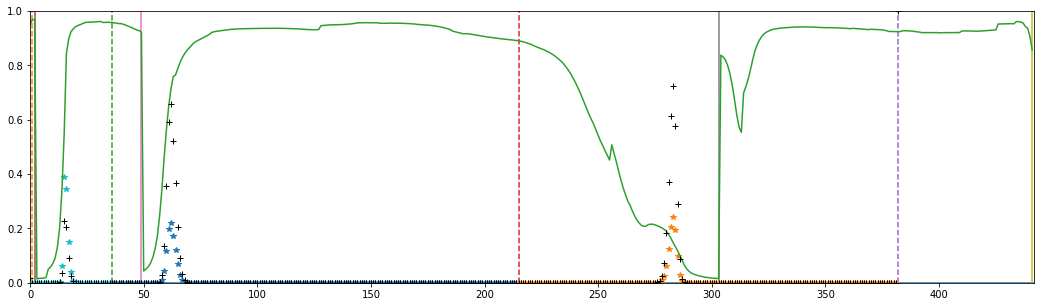

In [78]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18, 5))

ymax = 1
selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]

plt.plot([0, item[1][idx].item()], [0, 0])

for pivot in loaded_vidid_selected_frames[cur_vidid + ".txt"]:
    plt.plot([pivot, pivot], [0, ymax], '--')
    
for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, ymax])
    
all_prob = []
for i, segment in enumerate(prob_each_segment):
    segment = segment.cpu().numpy()
    print(f"Min prob {i} = {np.min(segment).item()}")
    xs = np.arange(loaded_vidid_selected_frames[cur_vidid + ".txt"][i], 
                   loaded_vidid_selected_frames[cur_vidid + ".txt"][i+1])
    plt.plot(xs, segment, '*')

    
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 
plt.plot(np.arange(item[1][idx].item()), plt_arr)


loss_prob = torch.softmax(cur_vid_feat.unsqueeze(0), dim=2)
es_loss, loss_arr = get_estimated_loss(loss_prob, torch.tensor([item_1[idx]]), [item[4][idx]], item_2[idx].unsqueeze(0))
loss_arr = -loss_arr[0].detach().cpu().numpy()
plt.plot(np.arange(selected_frames[0] - 1, selected_frames[-1] + 1), loss_arr/np.max(loss_arr), 'k+')

plt.ylim([0, ymax])
plt.xlim([0, item[1][idx].item()])

In [40]:
loss_prob = torch.softmax(cur_vid_feat.unsqueeze(0), dim=2)
print(loss_prob.shape)
es_loss, loss_arr = get_estimated_loss(loss_prob, torch.tensor([item_1[idx]]), [item[4][idx]], item_2[idx].unsqueeze(0))

torch.Size([1, 1895, 48])


In [43]:
loss_arr[0].shape

torch.Size([1387])

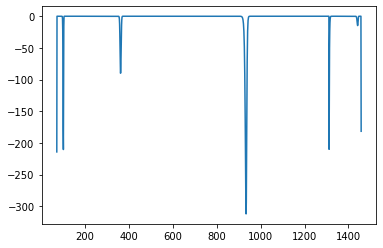

In [45]:
selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
plt.plot(np.arange(selected_frames[0] - 1, selected_frames[-1] + 1), loss_arr[0].detach().cpu().numpy())

In [44]:
es_loss

tensor(3.3987, device='cuda:0', dtype=torch.float64)

In [35]:
video_id_boundary_frames[cur_vidid], loaded_vidid_selected_frames[cur_vidid + ".txt"], item_1[idx]

([75, 345, 1305, 1415, 1440, 1519],
 [73, 282, 455, 1312, 1434, 1458],
 tensor(1520, device='cuda:0', dtype=torch.int32))

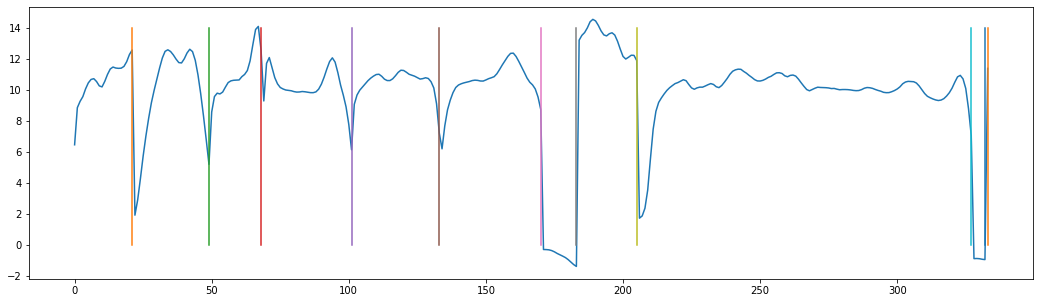

In [41]:
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 

fig = plt.figure(figsize=(18, 5))
plt.plot(np.arange(item[1][idx].item()), plt_arr)

for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, 14])

torch.Size([334, 334])

In [37]:
cur_features_shortened = cur_vid_feat[:item[1][idx]]
cur_features_shortened[:, item[2][idx][:item[1][idx]]].shape
for

torch.Size([334, 334])

In [26]:
item[2][idx][video_id_boundary_frames[cur_vidid][1]-6:video_id_boundary_frames[cur_vidid][1]+9]

tensor([47, 47, 47, 47, 47, 47, 47,  4,  4,  4,  4,  4,  4,  4,  4])

In [25]:
video_id_boundary_frames[cur_vidid][0]-6,video_id_boundary_frames[cur_vidid][0]+9

6

In [27]:
cur_vid_feat[video_id_boundary_frames[cur_vidid][1]-7:video_id_boundary_frames[cur_vidid][1]+9][:,[47,4]]

tensor([[ 1.0794, 13.3350],
        [ 1.0831, 13.5102],
        [ 1.1767, 13.7662],
        [ 1.3750, 14.0177],
        [ 1.7298, 14.1727],
        [ 2.1706, 14.0367],
        [ 2.7338, 13.4563],
        [ 4.5600, 12.1745],
        [ 7.8450, 10.3246],
        [11.0151,  8.3563],
        [13.4775,  6.6546],
        [14.1836,  5.2898],
        [11.2142,  4.2791],
        [ 5.9829,  3.5694],
        [ 2.3440,  2.9389],
        [ 0.7406,  2.3515]], device='cuda:0')

In [19]:
def add_frames_and_get_classification_value(model_output, count_list, video_ids_list, labels_all, p_criterion):
    new_selected_frames = {}
#     new_selected_frames_probs_values = {}
#     new_selected_frames_labels = {}
    
    labels_arr = []
    probs_arr = []
    
    for i, video_id in enumerate(video_ids_list):
        current_boundary_frames = boundaries_dict[video_id]
        current_video_logits = model_output[i].T
        current_video_count = count_list[i]
        current_selected_frames = loaded_vidid_selected_frames[video_id]
        labels = labels_all[i]
        cur_seg_start = 0
        for seg_num, ele in enumerate(current_boundary_frames):
            cur_seg_end = ele + 1
            total_seg_len = cur_seg_end - cur_seg_start
            per_frames_far_from_boundary = int(0.3 * total_seg_len)
            new_frames_start = cur_seg_start + per_frames_far_from_boundary
            new_frames_end = cur_seg_end - per_frames_far_from_boundary
            
            frames_added = list(range(new_frames_start, new_frames_end))
            frames_added.append(current_selected_frames[seg_num])
            frames_added = list(set(frames_added))
            frames_added.sort()
            new_selected_frames[video_id] = frames_added

            
            labels_seg = torch.stack([labels[current_selected_frames[seg_num]]] * len(frames_added))
            frames_added = torch.tensor(np.array(frames_added), dtype=torch.long, device=current_video_logits.device)
            prob_seg = current_video_logits[frames_added, :]
            
            labels_arr.append(labels_seg)
            probs_arr.append(prob_seg)
            
            cur_seg_start = cur_seg_end
            
    labels_arr = torch.cat(labels_arr)
    probs_arr = torch.cat(probs_arr)
    loss = p_criterion(probs_arr, labels_arr)
    return loss